Here we show how to use our models.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Add the relative path to the system path
sys.path.append(os.path.abspath("../train"))

from PIL import Image, ImageDraw, ImageFont

import torch as th
import torch.nn as nn
from torchvision import transforms

from ConvLSTM_model import ConvLSTM_Model
from utils import MnistSequenceDataset

from IPython.display import Image as IPython_Image

In [3]:
# Define function to add a border and title to a PIL image
def add_border_and_title(image, title, border_size=10, font_size=20, color="white"):
    # Add border
    width, height = image.size
    new_width = width + 2 * border_size
    new_height = height + 2 * border_size + font_size + 5  # Additional space for the title
    bordered_image = Image.new("RGB", (new_width, new_height), color=color)
    bordered_image.paste(image, (border_size, border_size + font_size + 5))
    # Add title text
    draw = ImageDraw.Draw(bordered_image)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    draw.text(((new_width-font_size)//4,border_size), title, fill="black", font=font)
    return bordered_image

In [4]:
seq_len = 9
data = np.load("../data/mnist/mnist_test_seq.npy").astype(np.float32)/255
train_idx = int(data.shape[1] * 0.8)
train_dataset = MnistSequenceDataset(data[:,:train_idx], seq_len, seq_len)
test_dataset = MnistSequenceDataset(data[:,train_idx:], seq_len, seq_len)

In [16]:
batch_size = 1
num_hidden = [64,32,32,16]
num_layers = len(num_hidden)
custom_model_config = {
    'in_shape': [1, 64, 64], # C, H, W
    'patch_size': 1,
    'filter_size': 3, 
    'stride': 2, 
    'layer_norm' : True,
    'transpose' : True,
    'bias' : False,
    'leaky_slope' : 0.2,
    'max_pool' : True
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Instantiate the model
input_dim = 3  # Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config)

CUDA is not available.


In [17]:
# Load the model
# Load the state dictionary
#model_64_32_32_16_936151.pth BEST MODEL!!!
# model_64_32_32_16_938207.pth more blurry
# model_64_32_32_16_938214.pth more blurry
# model_64_32_32_16_938948.pth doesn't work

state_dict = th.load('../models/model_64_32_32_16_936151.pth', map_location=th.device('cpu'), weights_only=True)

# Remove `module.` prefix if it exists
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(new_state_dict, strict=True)

<All keys matched successfully>

## Check the model on the test set

In [18]:
index = 0

input_frames = train_dataset[index][0]
output_frames = train_dataset[index][1]

input_pil_frames = [transforms.ToPILImage()(frame) for frame in input_frames]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in output_frames]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=10, loop=0)

input_frames = input_frames.unsqueeze(0)

mask_true = th.ones_like(input_frames)
predicted_frames = model(input_frames, mask_true, schedule_sampling=False)
input_frames = input_frames.squeeze(0)
predicted_frames = predicted_frames.squeeze(0)
print(predicted_frames.shape)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]


pred_gif_list = input_pil_frames + predicted_pil_frames

input_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Input Frame")
    for frame in input_frames
]
true_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Target Frame")
    for frame in output_frames
]
predicted_pil_frames = [
    add_border_and_title(transforms.ToPILImage()(frame), "Predicted Frame", color="red")
    for frame in predicted_frames
]

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite
true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save(
    'true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=0
)
pred_gif_list = input_pil_frames + predicted_pil_frames
pred_gif_list[0].save(
    'pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=0
)

torch.Size([9, 1, 64, 64])


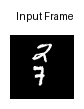

In [19]:
IPython_Image(filename='pred.gif')

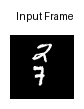

In [20]:
IPython_Image(filename='true.gif')

## Check the model on the test images

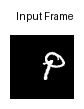

In [28]:
IPython_Image(filename='pred.gif')

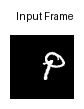

In [29]:
IPython_Image(filename='true.gif')